In [1]:
import os
import pandas as pd
import pprint
import numpy as np
import zipfile
import shutil
import matplotlib.pyplot as plt
%matplotlib inline
import csv

In [2]:
COLUMNS = ['Imu0_linear_accleration_x', 'Imu0_linear_accleration_y',
'Imu0_linear_accleration_z', 'Imu0_angular_velocity_x',
'Imu0_angular_velocity_y', 'Imu0_angular_velocity_z',
'Imu0_orientation_x', 'Imu0_orientation_y', 'Imu0_orientation_z',
'Imu0_orientation_w', 'Imu1_linear_accleration_x',
'Imu1_linear_accleration_y', 'Imu1_linear_accleration_z',
'Imu1_angular_velocity_x', 'Imu1_angular_velocity_y',
'Imu1_angular_velocity_z', 'Imu1_orientation_x', 'Imu1_orientation_y',
'Imu1_orientation_z', 'Imu1_orientation_w', 'Imu2_linear_accleration_x',
'Imu2_linear_accleration_y', 'Imu2_linear_accleration_z',
'Imu2_angular_velocity_x', 'Imu2_angular_velocity_y',
'Imu2_angular_velocity_z', 'Imu2_orientation_x', 'Imu2_orientation_y',
'Imu2_orientation_z', 'Imu2_orientation_w',
'imu0_to_imu1_translation_x', 'imu0_to_imu1_translation_y',
'imu0_to_imu1_translation_z', 'imu0_to_imu1_rotation_x',
'imu0_to_imu1_rotation_y', 'imu0_to_imu1_rotation_z',
'imu0_to_imu1_rotation_w', 'imu0_to_imu2_translation_x',
'imu0_to_imu2_translation_y', 'imu0_to_imu2_translation_z',
'imu0_to_imu2_rotation_x', 'imu0_to_imu2_rotation_y',
'imu0_to_imu2_rotation_z', 'imu0_to_imu2_rotation_w']


# Load Data

In [35]:
# Remove this on colab
pwd = "/Users/tablejai/Code/GitClones/time_series_augmentation"
train_data_dir = pwd + "/data_clean/"
train_label_dir = pwd +"/label/"
# train_data_dir = "/content/data_clean/"
# train_label_dir = "/content/label/"

# with zipfile.ZipFile("/content/label.zip") as data_zip:
#     data_zip.extractall("/content")

# with zipfile.ZipFile("/content/data_clean.zip") as data_zip:
#     data_zip.extractall("/content")

os.chdir(train_data_dir)
data_list = [train_data_dir + path for path in sorted(os.listdir())]

os.chdir(train_label_dir)
label_list = [train_label_dir + path for path in sorted(os.listdir())]

# Remove this on colab
# os.chdir("/content/")
os.chdir("/Users/tablejai/Code/GitClones/time_series_augmentation")

metadata_list = list()
for index, label_file_path in enumerate(label_list):
  label_file_data = pd.read_csv(label_file_path)._get_value(0, "label")
  imu_cmd_map = {"imu_data": data_list[index], "label": label_file_data}
  metadata_list.append(imu_cmd_map)
try:
  os.mkdir("data_clean_augment")
except OSError as error:
  print(error)
  print("folder already exists so nevermind")


[Errno 17] File exists: 'data_clean_augment'
folder already exists so nevermind


# Data Augmentation

In [39]:
# Adding normal distributed noise
def jitter(x, sigma=0.03):
  return x + np.random.normal(loc=0., scale=sigma, size=x.shape)

# Scaling (Quite literally)
def scaling(x, sigma=0.1):
  factor = np.random.normal(loc=1., scale=sigma, size=x.shape)
  return np.multiply(x, factor)


def time_warp(x, sigma=0.1, knot=4):
  from scipy.interpolate import CubicSpline
  orig_steps = np.arange(x.shape[0])

  random_warps = np.random.normal(
      loc=1.0, scale=sigma, size=(knot+2))
  warp_steps = np.linspace(0, x.shape[0]-1., num=knot+2).T

  time_warp = CubicSpline(warp_steps, warp_steps * random_warps)(orig_steps)
  scale = (x.shape[0]-1)/time_warp[-1]

  x = x.T
  ret = np.zeros_like(x)

  for col_index, col in enumerate(x):
      ret[col_index] = np.interp(orig_steps, np.clip(
          scale * time_warp, 0, x.shape[1]-1), col)
  return ret.T

# x = np.array([[1,2,3,4,5],[6,7,8,9,10], [11,12,13,14,15]])
# time_warp(x)


# Import Data

In [40]:
for data_file_label_dict in metadata_list:
  data_file_path = list(data_file_label_dict.items())[0][1]
  label_value = list(data_file_label_dict.items())[1][1]
  df = pd.read_csv(data_file_path)
  data_file_path = data_file_path.replace("/data_clean/", "/data_clean_augment/")
  original_df = df.copy(deep=True)
  
  timestamp_column = df.pop("timestamp")
  numpy_df_2d = df.to_numpy()
  numpy_df = numpy_df_2d.reshape((-1, numpy_df_2d.shape[0],numpy_df_2d.shape[1]))
  

  jitter_df = pd.DataFrame(jitter(numpy_df)[0], columns=COLUMNS)
  scaling_df = pd.DataFrame(scaling(numpy_df)[0], columns=COLUMNS)
  time_warp_df = pd.DataFrame(time_warp(numpy_df_2d), columns=COLUMNS)

  jitter_df["timestamp"] = timestamp_column
  scaling_df["timestamp"] = timestamp_column
  time_warp_df["timestamp"] = timestamp_column

  # Write to new data csv
  jitter_df.to_csv(data_file_path[:-4] + "_jitter.csv", index=False)
  scaling_df.to_csv(data_file_path[:-4] + "_scaling.csv", index=False)
  time_warp_df.to_csv(data_file_path[:-4] + "_time_warp.csv", index=False)

  # Write to new label csv
  pd.DataFrame({"label": [label_value]}).to_csv(data_file_path.replace(train_data_dir, train_label_dir)[:-8] + "label_jitter.csv", index=False)
  pd.DataFrame({"label": [label_value]}).to_csv(data_file_path.replace(train_data_dir, train_label_dir)[:-8] + "label_scaling.csv", index=False)
  pd.DataFrame({"label": [label_value]}).to_csv(data_file_path.replace(train_data_dir, train_label_dir)[:-8] + "label_time_warp.csv", index = False)


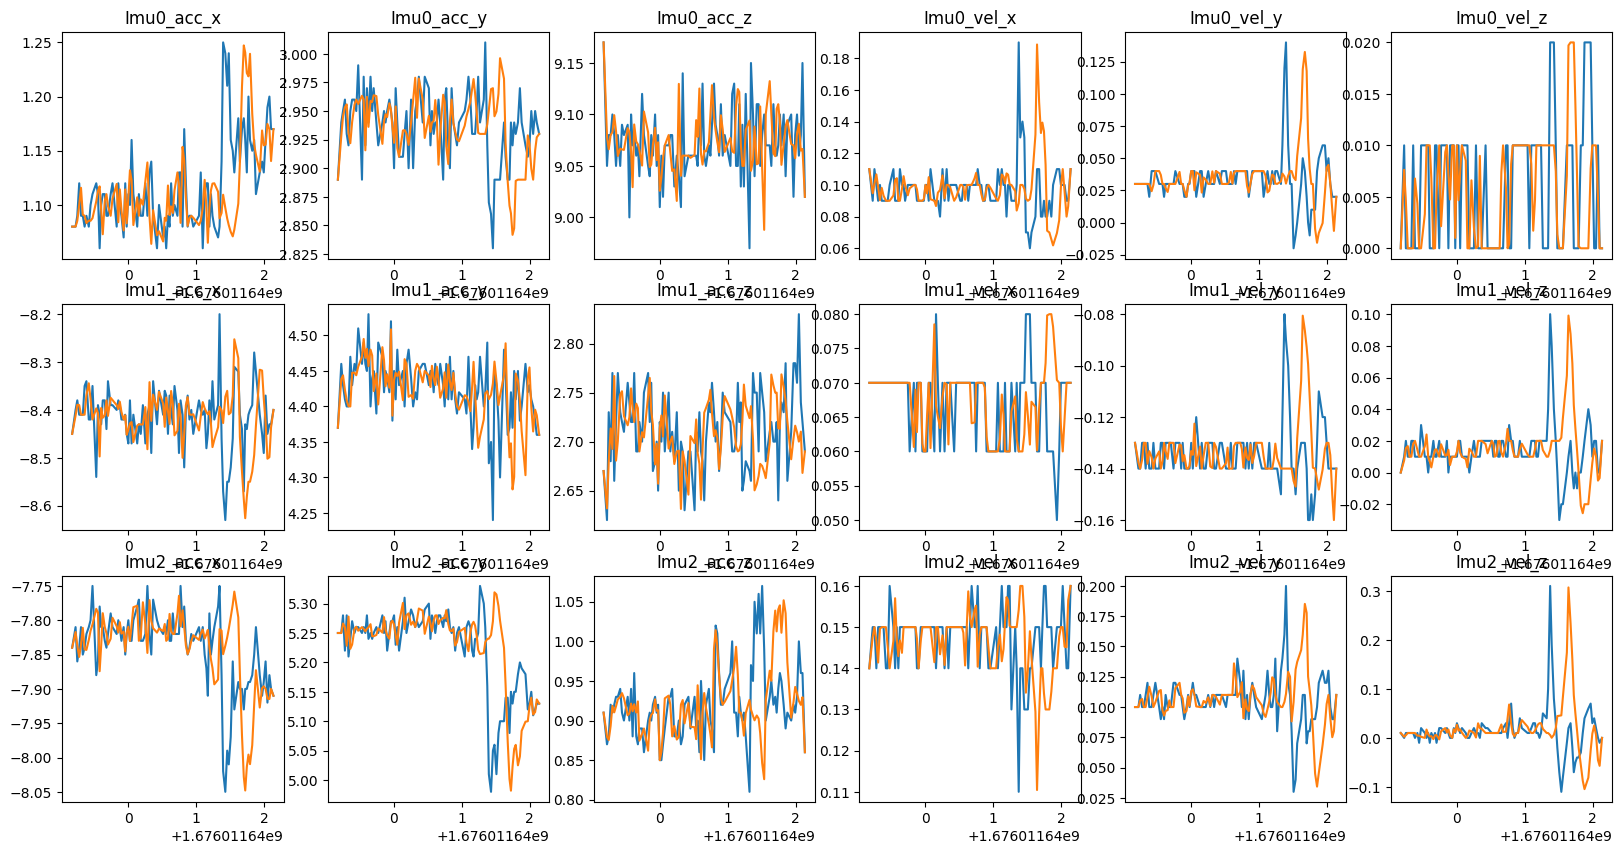

In [41]:
fig, axs = plt.subplots(3, 6, figsize=(20, 10))
augment_data = pd.read_csv(
    "/Users/tablejai/Code/GitClones/time_series_augmentation/data_clean/rosbag2_2023_02_10-08_08_44_data_time_warp.csv")
raw_data = pd.read_csv(
    "/Users/tablejai/Code/GitClones/time_series_augmentation/data_clean/rosbag2_2023_02_10-08_08_44_data.csv")

acc_axes = axs[:, :3].ravel()
vel_axes = axs[:, 3:].ravel()
acc_data = [raw_data[f'Imu{i}_linear_accleration_{xyz}']
        for i in range(3) for xyz in ['x', 'y', 'z']]
augment_acc_data = [augment_data[f'Imu{i}_linear_accleration_{xyz}']
        for i in range(3) for xyz in ['x', 'y', 'z']]
vel_data = [raw_data[f'Imu{i}_angular_velocity_{xyz}']
            for i in range(3) for xyz in ['x', 'y', 'z']]
augment_vel_data = [augment_data[f'Imu{i}_angular_velocity_{xyz}']
            for i in range(3) for xyz in ['x', 'y', 'z']]
acc_titles = [f'Imu{i}_acc_{xyz}' for i in range(3) for xyz in [
    'x', 'y', 'z']]
vel_titles = [f'Imu{i}_vel_{xyz}' for i in range(3) for xyz in [
    'x', 'y', 'z']]

for ax, data, augment_ax, title in zip(acc_axes, acc_data, augment_acc_data, acc_titles):
    ax.plot(raw_data['timestamp'], data)
    ax.plot(augment_data['timestamp'], augment_ax)
    ax.set_title(title)

for ax, data,augment_ax, title in zip(vel_axes, vel_data, augment_vel_data, vel_titles):
    ax.plot(raw_data['timestamp'], data)
    ax.plot(augment_data['timestamp'], augment_ax)
    ax.set_title(title)
